# Use Pixtral 12B for multimodal AI queries in Python with watsonx

**Authors:** Anna Gutowska and Erika Russi

In this tutorial, you will discover how to apply Mistral AI’s [Pixtral 12B](https://mistral.ai/news/pixtral-12b/) multimodal model now available on [watsonx.ai](https://www.ibm.com/products/watsonx-ai) for
multimodal tasks such as image captioning and visual question answering.

## Pixtral 12B

In September 2024, Mistral AI launched Pixtral 12B, an open-source [large language model (LLM)](https://www.ibm.com/topics/large-language-models) under the Apache 2.0 license.

With 12 billion parameters, the multimodal model is built on Mistral AI's [Nemo 12B LLM](https://mistral.ai/news/mistral-nemo). Pixtral 12B has two components: the vision encoder to tokenize images and a multimodal transformer decoder to predict the following text token given a sequence of text and images. The vision encoder has 400 million parameters and supports variable image sizes.

The model excels at multiple use cases, including understanding graphs, diagrams, charts and documents in high resolution, which may be used for document question answering, instruction following or [retrieval augmented generation (RAG)](https://research.ibm.com/blog/retrieval-augmented-generation-RAG) tasks. Additionally, Pixtral 12B has a 128,000-token context window, which allows for the consumption of multiple images simultaneously.

In terms of benchmarks, Pixtral 12B outperforms various models, including Qwen2-VL, Gemini-1.5 Flash 8B and Claude-3 Haiku. For certain benchmarks, including DocVQA (ANLS) and VQAv2 (VQA Match), the model outperforms OpenAI's GPT-4o and Claude-3.5 Sonnet.

Besides being able to run Pixtral 12B on watsonx.ai, the model is also available via [Hugging Face](https://huggingface.co/mistralai/Pixtral-12B-2409), on Le Chat, Mistral's conversational chatbot, or via API endpoint through Mistral's La Plateforme.

# Steps

**Please check out this [YouTube video](https://www.youtube.com/watch?v=3sav6vUG_XQ) that walks you through the following set up instructions in Steps 1 and 2.**

## Step 1. Set up your environment

While you can choose from several tools, this tutorial is best suited for a Jupyter Notebook. Jupyter Notebooks are widely used within data science to combine code with various data sources like text, images and data visualizations.

This tutorial walks you through how to set up an IBM account to use a Jupyter Notebook.

1. Log in to [watsonx.ai](https://eu-gb.dataplatform.cloud.ibm.com/login?context=wx) using your IBM Cloud account. Please note that Pixtral 12B is currently only available on the IBM Europe Frankfurt and London regions.

2. Create a [watsonx.ai project](https://www.ibm.com/docs/en/watsonx/saas).

	You can get your project ID from within your project. Click the Manage tab. Then, copy the project ID from the Details section of the General page. You need this ID for this tutorial.

3. Create a [Jupyter Notebook](https://www.ibm.com/docs/en/watsonx/saas).

This step will open a Notebook environment where you can copy the code from this tutorial to implement an AI agent of your own. Alternatively, you can download this notebook to your local system and upload it to your watsonx.ai project as an asset. This Jupyter Notebook is available on [GitHub](https://github.com/IBM/ibmdotcom-tutorials/blob/main/generative-ai/pixtral-multimodal-ai.ipynb).

To avoid Python package dependency conflicts, we recommend setting up a [virtual environment](https://docs.python.org/3/library/venv.html).

## Step 2. Set up watsonx.ai Runtime service and API key

1. Create a [watsonx.ai Runtime](https://cloud.ibm.com/catalog/services/watsonxai-runtime) service instance (choose the Lite plan, which is a free instance).

2. Generate an [API Key](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-authentication.html).

3. Associate the watsonx.ai Runtime service to the project you created in [watsonx.ai](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/assoc-services.html?context=cpdaas).

## Step 3. Install and import relevant libraries and set up your credentials

We'll need a few libraries and modules for this tutorial. Make sure to import the following ones; if they're not installed, you can resolve this with a quick pip install.

In [68]:
#installations
%pip install image | tail -n 1
%pip install -U "ibm_watsonx_ai>=1.1.14" | tail -n 1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [69]:
#imports
import requests
import base64
import getpass
import textwrap

from PIL import Image
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference

Input your `WATSONX_EU_APIKEY` and `WATSONX_EU_PROJECT_ID` that you created in steps 1 and 2 upon running the following cell. We will also set the URL serving as the API endpoint.

In [70]:
WATSONX_EU_APIKEY = ("2IbWemJTCRGEgnJ8NHWZLgnf-IiVtbgcxCOEHPOnZUAe")

WATSONX_EU_PROJECT_ID = ("4a3a40dc-22a6-475b-9a7b-299b1d138903")

URL = "https://eu-gb.ml.cloud.ibm.com"

We can use the `Credentials` class to encapsulate our passed credentials.

In [71]:
credentials = Credentials(
    url=URL,
    api_key=WATSONX_EU_APIKEY
)

## Step 4. Encode images

In this tutorial, we will be working with several images for multimodal AI applications such as image captioning and object detection. The images we will be using can be accessed using the following URLs. We can store these URLs in a list to iteratively encode them.

In [72]:
url_image_1 = 'https://hsc.unm.edu/medicine/departments/dermatology/_images/skin-atlas/acne/acne-type-iv.jpg'
url_image_2 = 'https://hsc.unm.edu/medicine/departments/dermatology/_images/skin-atlas/acne/acne-type-i.jpg'

image_urls = [url_image_1, url_image_2]

To gain a better understanding of our data input, let's display the images.

url_image_0


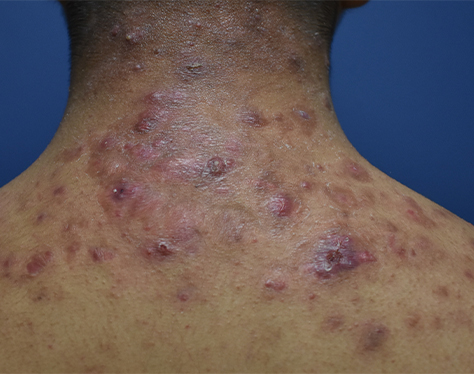

url_image_1


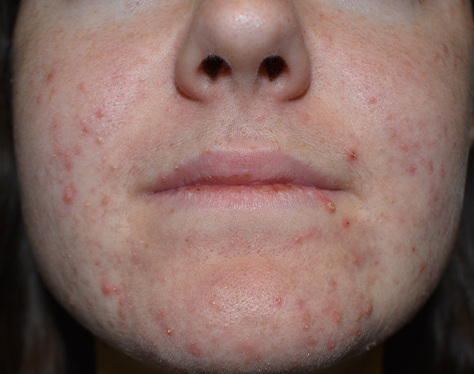

In [73]:
for idx, url in enumerate(image_urls):
    print(f'url_image_{idx}')
    display(Image.open(requests.get(url, stream=True).raw))

To encode these images in a way that is digestible for the LLM, we will be encoding the images to bytes that we then decode to UTF-8 representation.

In [74]:
encoded_images = []

for url in image_urls:
    encoded_images.append(base64.b64encode(requests.get(url).content).decode("utf-8"))

In [75]:
# encoded_images

## Step 5. Set up the API request and LLM

Now that our images can be passed to the LLM, let's set up a function for our watsonx API calls. The `augment_api_request_body` function takes the user query and image as parameters and augments the body of the API request. We will use this function in each iteration.

In [76]:
def augment_api_request_body(user_query, image):

    messages = [
        {
            "role": "user",
            "content": [{
                "type": "text",
                "text": 'You are a helpful assistant. Answer the following user query in 1 or 2 sentences: ' + user_query
            },
            {
                "type": "image_url",
                "image_url": {
                "url": f"data:image/jpeg;base64,{image}",
                }
            }]
        }
    ]

    return messages

Let's instantiate the model interface using the `ModelInference` class. In this tutorial, we will use the the `mistralai/pixtral-12b` model.

In [77]:
model = ModelInference(
    model_id="mistralai/pixtral-12b",
    credentials=credentials,
    project_id=WATSONX_EU_PROJECT_ID,
    params={
        "max_tokens": 200
      }
)

/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/ibm_watsonx_ai/foundation_models/utils/utils.py:436: LifecycleWarning: Model 'mistralai/pixtral-12b' is in deprecated state from 2025-07-09 until 2025-10-08. IDs of alternative models: mistralai/mistral-small-3-1-24b-instruct-2503. Further details: https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-model-lifecycle.html?context=wx&audience=wdp
  warn(model_state_warning, category=LifecycleWarning)


In [78]:
model1 = ModelInference(
    model_id="meta-llama/llama-3-2-11b-vision-instruct",
    credentials=credentials,
    project_id=WATSONX_EU_PROJECT_ID,
    params={
        "max_tokens": 200
      }
)

In [100]:
for i in range(len(encoded_images)):

	image = encoded_images[i]

	user_query = "What kind of disease this person is having?"

	messages = augment_api_request_body(user_query, image)

	response = model.chat(messages=messages)
	response1 = model1.chat(messages=messages)

	print("<== Response by Pixtral 12B model ==> ")
	print(textwrap.fill(response['choices'][0]['message']['content'], width=100),"\n")

	print("<== Response by llama 11b vision-instruct model ==> ")
	print(textwrap.fill(response1['choices'][0]['message']['content'], width=100),"\n")

<== Response by Pixtral 12B model ==> 
The person in the image appears to have a severe skin condition, possibly a type of acne, psoriasis,
or a severe allergic reaction, indicated by the presence of numerous red, inflamed bumps and lesions
on their neck and back. 

<== Response by llama 11b vision-instruct model ==> 
The person in the image appears to be experiencing a skin condition characterized by the presence of
acne, which is a common skin disease that occurs when pores on the skin become clogged with oil and
dead skin cells. 

<== Response by Pixtral 12B model ==> 
The person in the image appears to be suffering from acne, as indicated by the presence of red bumps
and pimples on their face. 

<== Response by llama 11b vision-instruct model ==> 
The person in the image appears to be experiencing acne, a common skin condition characterized by
the occurrence of pimples, blackheads, and whiteheads. 



Failure during chat. (POST https://eu-gb.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-07-16)
Status code: 500, body: {"errors":[{"code":"downstream_request_failed","message":"Downstream vllm request failed: Internal Server Error","more_info":"https://cloud.ibm.com/apidocs/watsonx-ai#text-chat"}],"trace":"a5a8dc4b41052d4a1378f374b02876c6","status_code":500}


ApiRequestFailure: Failure during chat. (POST https://eu-gb.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-07-16)
Status code: 500, body: {"errors":[{"code":"downstream_request_failed","message":"Downstream vllm request failed: Internal Server Error","more_info":"https://cloud.ibm.com/apidocs/watsonx-ai#text-chat"}],"trace":"a5a8dc4b41052d4a1378f374b02876c6","status_code":500}